# 速習 時系列分析

## Agenda

1. 定常性
2. 自己相関
3. AR
4. MA
5. ARMA
6. ARIMA
7. Optional(ARIMAX, SARIMAX, 状態空間モデル)
8. 宿題

本notebookでは[時系列分析と状態空間モデルの基礎: RとStanで学ぶ理論と実装](https://www.amazon.co.jp/dp/4903814874/ref=cm_sw_em_r_mt_dp_U_l.e.CbRPGQDN8)の内容に沿いながら、時系列分析でよく用いられるモデルを概観していく。詳細については上記書籍を参照。  
また、上記書籍は入門的な内容であり、数学的な導出など、詳細な議論については扱っていない。そうした詳細について学びたい場合は、例えば以下の書籍を参照。
- [Time Series Analysis(Hamilton, 1994)](https://www.amazon.com/Time-Analysis-James-Douglas-Hamilton/dp/0691042896)
    - 英語。(日本語訳は上巻が絶版となってしまった。)上述の各モデルを含む、時系列分析一般について幅広く網羅している。
- [経済・ファイナンスデータの計量時系列分析(沖本, 2010)]( https://www.amazon.co.jp/dp/4254127928/ref=cm_sw_em_r_mt_dp_U_L0e.CbV02W617)
    - 日本語。上記の"Time Series Analysis"への橋渡しとして書かれた本。コンパクトにまとめられており、わかりやすい。

## 平均・分散・自己共分散・自己相関

- 時系列データであっても、期待値や分散などの統計量は時系列の特徴を表す重要な尺度となる。

**平均**  
$\mu_{t} = E[y_{t}]$  
ここでの平均$\mu_{t}$は、例えばyが時点tにおける気温であれば、イメージとしては「いくつか平行世界があった場合の、時点tの平均温度」であり、1週間の気温の平均ではない。  
ただし、実際には我々は平行世界を確認できるわけではないので、次項の**定常性**を仮定し、分析を行う。

**分散**  
$Var(y_{t}) = E[(y_{t} - \mu_{t})^2]$  
ここでの分散$Var(y_{t})$も、平均の場合と同様、1週間の気温の分散ではなく、「いくつか平行世界があった場合の、時点tの分散」である。

**自己共分散**  
$\gamma_{k, t} = Cov(y_{t}, y_{t-k}) = E[(y_{t} - \mu_{t})(y_{t-k} - \mu_{t-k})]$  
時点tのyと時点t-kのyの共分散をk次の自己共分散と呼ぶ。

**自己相関**  
自己共分散は通常の共分散同様、時系列の大きさによって値が異なるため、標準偏差で割ることで、相関係数を定義する。  
$\rho_{k, t} = Corr(y_{t}, y_{t-k}) = \frac{Cov(y_{t}, y_{t-k})}{\sqrt{Var(y_{t})Var(y_{t-k})}}$  

**偏自己相関**  
時点tと時点t-kの自己相関を計算する際に、その間の時点t-1, 時点t-2, ...時点t-k+1の影響を除いて計算された自己相関。  
$\hat{y_{t}}$、$\hat{y_{t_k}}$を、時点t-1...時点t-k+1との相関から予測されたyの値だとすると、偏自己相関は以下のように書ける。  
$P_{k, t} = \frac{Cov(y_{t} - \hat{y_{t}}, y_{t-k} - \hat{y_{t-k}})}{Var(y_{t} - \hat{y_{t}})Var(y_{t-k} - \hat{y_{t-k}})}$  
以下の方程式の解として得られることが知られている。
$$\begin{pmatrix}
1 & \rho (1, t) & \cdots & \rho (k-1, t) \\ \rho (1, t) & 1 & \cdots & \rho (k-2, t) \\ \vdots & \vdots & \ddots & \vdots \\ \rho (k-1, t) & \rho (k-2, t) & \cdots & 1
\end{pmatrix}
\begin{pmatrix}
P_{1, t} \\ P_{2, t} \\ \vdots \\ P_{k, t}
\end{pmatrix}
=
\begin{pmatrix}
\rho (1, t) \\ \rho (2, t) \\ \vdots \\ \rho (k, t)
\end{pmatrix}$$

自己相関は、例えばstatsmodelsを使って以下のように計算できる。

In [1]:
import statsmodels.api as sm
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.set_index("YEAR", inplace=True)

In [2]:
sunspots.head()

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0


In [3]:
sunspots.tail()

,SUNACTIVITY
YEAR,
2004.0,40.4
2005.0,29.8
2006.0,15.2
2007.0,7.5
2008.0,2.9


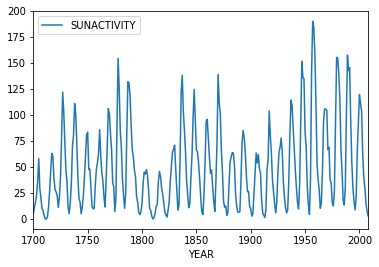

In [4]:
sunspots.plot()

In [5]:
sm.tsa.stattools.acf(sunspots, nlags=40) # 0 ~ 40までの自己相関

array([ 1.        ,  0.82020129,  0.45126849,  0.03957655, -0.27579196,
       -0.42523943, -0.37659509, -0.15737391,  0.15820254,  0.47309753,
        0.65898002,  0.65029082,  0.45666254,  0.16179329, -0.12205105,
       -0.3161808 , -0.37471125, -0.30605753, -0.1348069 ,  0.09158727,
        0.2975632 ,  0.4207074 ,  0.41183954,  0.27020758,  0.04496208,
       -0.17428715, -0.33045026, -0.37287834, -0.28555061, -0.11794414,
        0.08293231,  0.24897507,  0.32752101,  0.28335919,  0.1375272 ,
       -0.05526386, -0.22973205, -0.31338879, -0.29355684, -0.17897285,
       -0.01769038])

In [6]:
sm.tsa.stattools.pacf(sunspots, nlags=40) # 0 ~ 40までの偏自己相関

array([ 1.00000000e+00,  8.22864286e-01, -6.90310216e-01, -1.40572128e-01,
        5.60804025e-02,  4.90077270e-03,  1.82247989e-01,  2.19939368e-01,
        2.28436387e-01,  2.62692745e-01, -1.64957719e-02, -7.62590556e-03,
       -1.50968950e-02, -8.28648718e-04,  6.16072896e-02, -8.27061703e-02,
       -7.88015856e-02, -1.62447551e-01, -9.12918340e-02,  4.47916043e-02,
        2.45683035e-03,  1.12617329e-01, -1.31318378e-03, -9.92893352e-02,
       -5.70561869e-02,  2.29911661e-02, -6.61542747e-02,  9.74598824e-02,
        1.11323622e-01, -1.26321199e-01,  2.49774293e-02, -4.76464467e-02,
       -1.07618291e-02,  5.20777678e-03,  9.02935874e-03,  2.03912400e-02,
       -4.84266992e-02,  6.88517686e-02, -4.06046146e-02,  4.47681852e-02,
        4.77286574e-02])

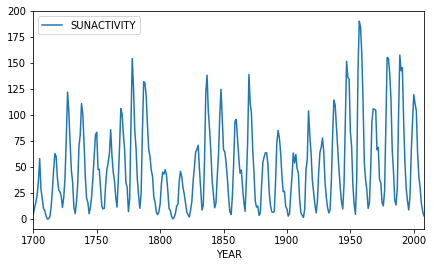

In [7]:
sunspots.plot(figsize=(7,4))

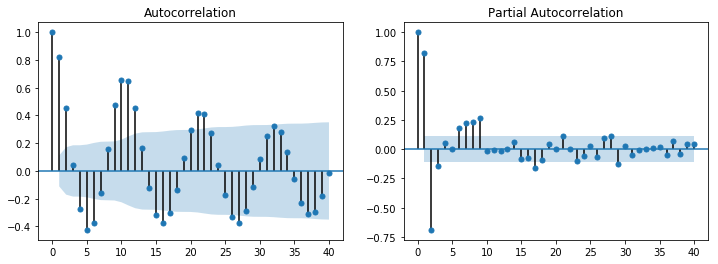

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sm.graphics.tsa.plot_acf(sunspots, lags=40, ax=ax1)
ax2 = plt.subplot(1,2,2)
sm.graphics.tsa.plot_pacf(sunspots, lags=40, ax=ax2)
plt.show()

## 定常性

- 以下の性質を**弱定常性**と呼び、弱定常性を持つ時系列を**定常過程**と呼ぶ。
    - 平均が時点に依らず一定: $E[y_{t}] = \mu$
    - 自己共分散が時点に依らず一定: $Cov(y_{t}, y_{t-k}) = E[(y_{t} - \mu)(y_{t-k} - \mu)] = \gamma_{k}$
    - **要するに、データの平均・ばらつき・自己相関が時点に依らず一定、という性質。分析がしやすくなる。**
- AR, MA, ARMAは定常過程の時系列を対象としたモデル。**非定常の過程には適用できない。**
- ARIMA(ARIMAX, SARIMAなどの派生も含む)は差分を取ることで定常となる時系列を対象としたモデル。**大体の場合において、差分をとれば定常となる。**

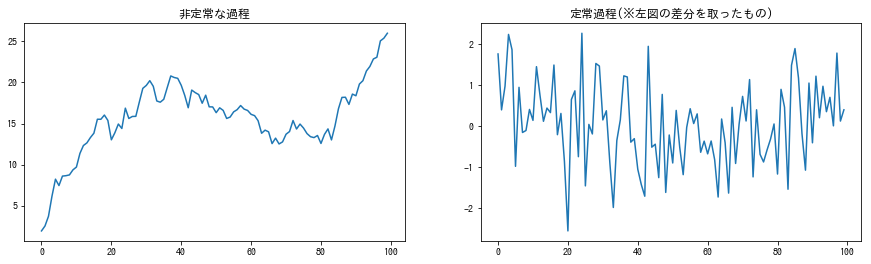

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "IPAGothic"
np.random.seed(0)
whitenoise = np.random.randn(100)
rw = (whitenoise + 0.2).cumsum()
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(rw)
plt.title("非定常な過程")
plt.subplot(1,2,2)
plt.plot(whitenoise)
plt.title("定常過程(※左図の差分を取ったもの)")
plt.show()

## AR model(AutoRegressive model, 自己回帰モデル)

**モデルの説明**  
対象の変数$y$の現在の値が、過去の$y$値の線形和によって説明されるとするモデル。  
例えば1次のARモデルは以下の式で書ける。  
$$y_{t} = \phi_{1}y_{t-1} + \epsilon_{t}$$
ここで、$\epsilon_{t}$は平均0, 分散$\sigma$の正規分布$N(0,\sigma)$に従う誤差項(ホワイトノイズ)である。

p次のARモデルは以下。AR(p)と表記される。
$$y_{t} = \sum_{i=1}^{p}\phi_{i}y_{t-i} + \epsilon_{t}$$

**平均と分散**


**AR modelの例**

In [10]:
whitenoise = np.random.rand(100)

In [11]:
def make_ar(coefs, length=100, random_seed=0):
    np.random.seed(random_seed)
    whitenoise = np.random.randn(length)
    ar_series = np.ndarray(length)
    ar_series[0] = whitenoise[0]
    for i in range(1, length):
        ar_series[i] = whitenoise[i]
        for j, coef in enumerate(coefs):
            ar_series[i] += coef * ar_series[i-(j+1)]
    return ar_series

In [12]:
ar = []
coefs = [[0.5], [-0.5], [1], [1.2], [-1.3]]
for i in coefs:
    ar.append(make_ar(i))

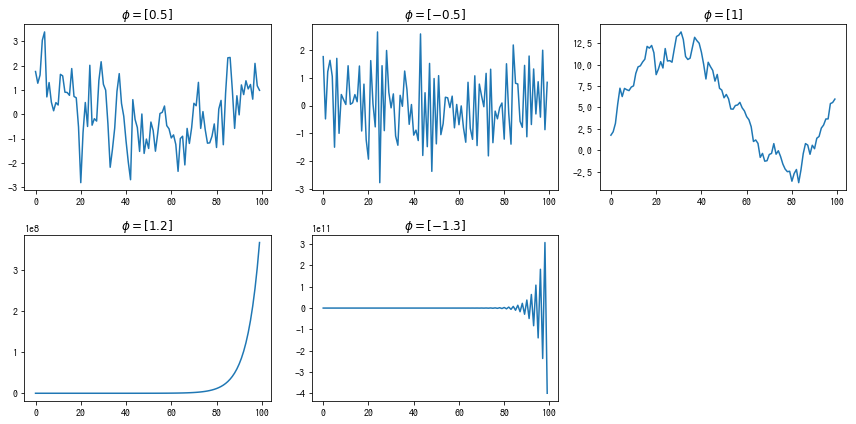

In [13]:
plt.figure(figsize=(12,6))
for i, series in enumerate(ar):
    plt.subplot(2,3,i+1)
    plt.plot(series)
    plt.title(f"$\phi = {coefs[i]}$")
    plt.tight_layout()

**係数について**
- 1次のARモデルの場合、係数$\phi_{1}$が1より小さい場合に定常過程、1以上の場合には発散する。1の場合にはランダムウォークと呼ばれる過程となる。
- 係数が1に近いと、直前の値に近い値となるため、滑らかな過程となる。
- 係数が1の時のランダムウォーク過程は単位根過程とも呼ばれる。株価など、経済系の時系列は単位根過程のものも多い。
- 係数が負になると、ギザギザした過程となる。

- p次のARモデルの場合、特性方程式$$1 - \phi_{1}z - \phi_{2}z^{2} ... - \phi_{p}z^{p} = 0$$の解の絶対値が1より大きい場合に定常過程となる。

**AR modelのコレログラム**

In [14]:
from pandas.plotting import autocorrelation_plot # pandasにも自己相関を計算する関数がある

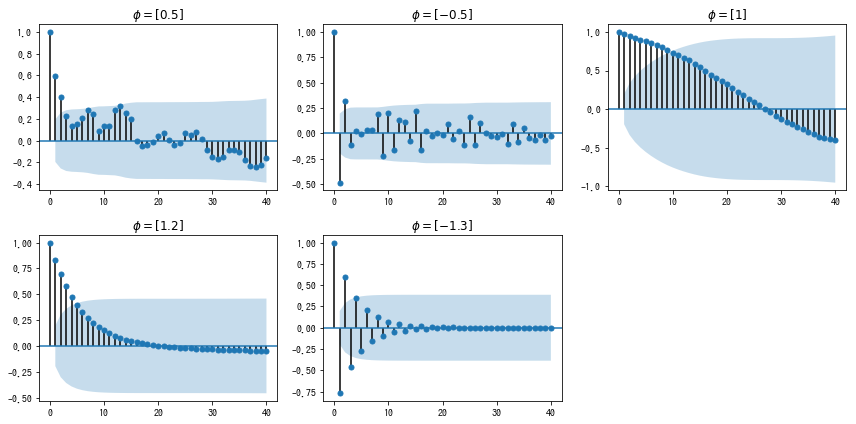

In [15]:
plt.figure(figsize=(12,6))
for i, series in enumerate(ar):
    ax = plt.subplot(2,3,i+1)
    sm.graphics.tsa.plot_acf(ar[i], lags=40, ax = ax);
    plt.title(f"$\phi = {coefs[i]}$")
    plt.tight_layout()

## MA model(Moving Average model, 移動平均モデル)

**モデルの説明**  
対象の変数$y$の現在の値が、過去のホワイトノイズの値の線形和によって説明されるとするモデル。  
例えば1次のMAモデルは以下の式で書ける。  
$$y_{t} = \theta_{1}\epsilon_{t-1} + \epsilon_{t}$$
ここで、$\epsilon_{t}$は平均0, 分散$\sigma$の正規分布$N(0,\sigma)$に従う誤差項(ホワイトノイズ)である。


q次のMAモデルは以下。MA(q)と表記される。
$$y_{t} = \sum_{i=1}^{q}\theta_{i}\epsilon_{t-i} + \epsilon_{t}$$

過去の変数$y$の値から直接的に現在の$y$が説明されるAR modelと異なり、まずホワイトノイズがあり、そのホワイトノイズに重みを付けて移動平均を取ることで、現在の$y$が説明されるという考え方がMA modelである。

**移動平均モデルの例**

In [16]:
def make_ma(coefs, length=100, random_seed=0):
    np.random.seed(random_seed)
    whitenoise = np.random.randn(length)
    ma_series = np.ndarray(length)
    ma_series[0] = whitenoise[0]
    for i in range(1, length):
        ma_series[i] = whitenoise[i]
        for j, coef in enumerate(coefs):
            ma_series[i] += coef * whitenoise[i-(j+1)]
    return ma_series

In [17]:
ma = []
coefs_ma = [[0.5], [0.5, 0.4], [0.5, 0.4, 0.3], [-0.5], [-0.5, -0.4], [-0.5, -0.4, -0.3]]
for i in coefs_ma:
    ma.append(make_ma(i, length=100))

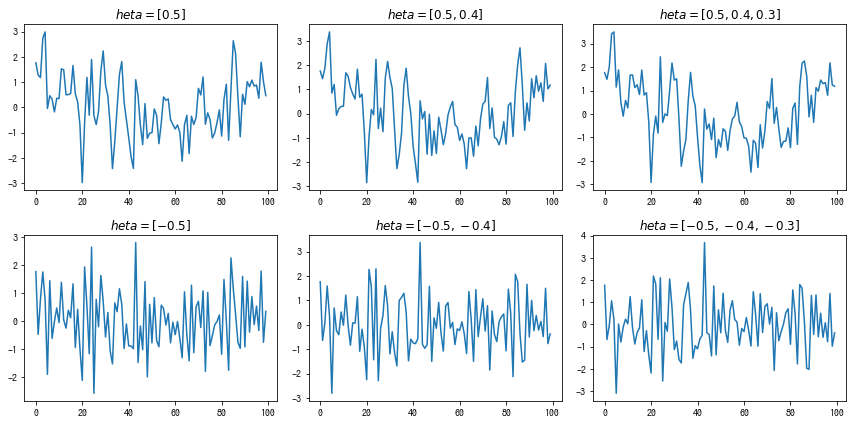

In [18]:
plt.figure(figsize=(12,6))
for i, series in enumerate(ma):
    plt.subplot(2,3,i+1)
    plt.plot(series)
    plt.title(f"$\theta = {coefs_ma[i]}$")
    plt.tight_layout()

**特徴**  
- MAモデルは常に定常過程となる
- 次数qが高くなるほど、共有するホワイトノイズが多くなるため、滑らかな過程となる。
- 係数がお互いに近い値となるほど、滑らかな過程となる。

**移動平均モデルのコレログラム**

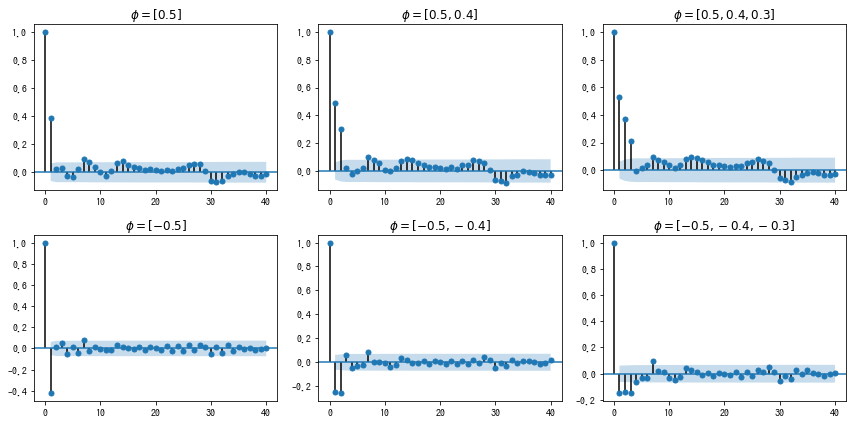

In [19]:
ma = []
coefs_ma = [[0.5], [0.5, 0.4], [0.5, 0.4, 0.3], [-0.5], [-0.5, -0.4], [-0.5, -0.4, -0.3]]
for i in coefs_ma:
    ma.append(make_ma(i, length=1000))

plt.figure(figsize=(12,6))
for i, series in enumerate(ma):
    ax = plt.subplot(2,3,i+1)
    sm.graphics.tsa.plot_acf(ma[i], lags=40, ax = ax);
    plt.title(f"$\phi = {coefs_ma[i]}$")
    plt.tight_layout()

## ARMA model(AutoRegressive Moving Average model, 自己回帰移動平均モデル)

**モデルの説明**  
ARモデルとMAモデルの合わせ技。
ARがp次, MAがq次のARMAモデルは以下。ARMA(p,q)と表記される。
$$y_{t} = \sum_{i=1}^{p}\phi_{i}y_{t-i} + \sum_{i=1}^{q}\theta_{i}\epsilon_{t-i} 
+ \epsilon_{t}$$
第1項がARモデル部分、第2項がMAモデル部分となる。

**自己回帰移動平均モデルの例**

In [20]:
def make_arma(coefs_ar, coefs_ma, length=100, random_seed=0):
    np.random.seed(random_seed)
    whitenoise = np.random.randn(length)
    arma_series = np.ndarray(length)
    arma_series[0] = whitenoise[0]
    for i in range(1, length):
        arma_series[i] = whitenoise[i]
        for j, coef in enumerate(coefs_ma):
            arma_series[i] += coef * whitenoise[i-(j+1)]
        for j, coef in enumerate(coefs_ar):
            arma_series[i] += coef * arma_series[i-(j+1)]
    return arma_series

**自己回帰移動平均モデルの例**

In [21]:
arma = make_arma([0.5], [0.5], length=1000)

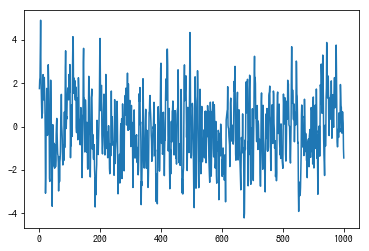

In [22]:
plt.plot(arma)

**自己回帰移動平均モデルのコレログラム**

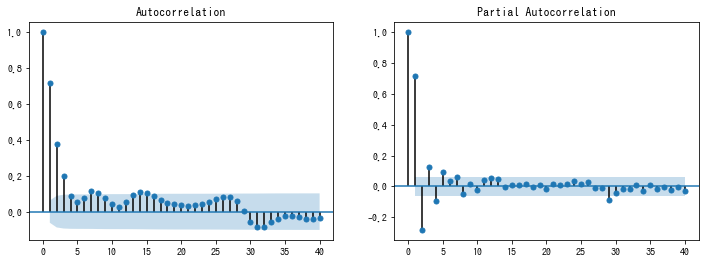

In [23]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sm.graphics.tsa.plot_acf(arma, lags=40, ax=ax1)
ax2 = plt.subplot(1,2,2)
sm.graphics.tsa.plot_pacf(arma, lags=40, ax=ax2)
plt.show()

**モデリング**

In [24]:
from statsmodels.tsa.arima_model import ARMA
m_ARMA = ARMA(sunspots, order=(1, 1)).fit() # orderはp,qの順

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [25]:
m_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                     ARMA(1, 1)   Log Likelihood               -1352.613
Method:                       css-mle   S.D. of innovations             19.214
Date:                Tue, 11 Jun 2019   AIC                           2713.226
Time:                        16:18:21   BIC                           2728.160
Sample:                             0   HQIC                          2719.197
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                48.7962      6.219      7.847      0.000      36.608      60.984
ar.L1.SUNACTIVITY     0.7355      0.041     18.035      0.000       0.656       0.815
ma.L1.SUNACTIVITY     0.5194      0.041     12.810      0.000       0.440       0.599
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3596           +0.0000j            1.3596            0.0000
MA.1           -1.9252           +0.0000j            1.9252            0.5000
-----------------------------------------------------------------------------
"""

In [26]:
sunspots.shape

(309, 1)

In [27]:
predicted = m_ARMA.predict(start=309, end=309 + 99)

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


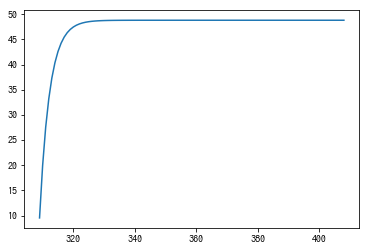

In [28]:
plt.plot(predicted) # 将来を100ステップ予測

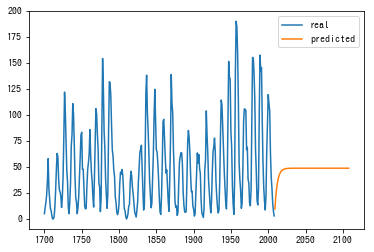

In [29]:
plt.plot(np.arange(1700, 2009), sunspots.values, label="real")
plt.plot(np.arange(2009,2009+100), predicted.values, label="predicted")
plt.legend()

## ARIMA model(AutoRegressive Integrated Moving Average model, 差分自己回帰移動平均モデル)

**モデルの説明**  
時系列の差分をとって得られた時系列について、ARMAモデルを適用するモデル。  
非定常な時系列であっても、差分を取ることで定常となる時系列は多い。  
(例えば株価は対数を取ってから1次の差分を取ることで定常過程となり、不動産価格は2次の差分を取ることで定常過程となることが知られている)

差分がd次、ARがp次, MAがq次のARMAモデルは以下。ARIMA(p,d,q)と表記される。
$$z_{t} = \sum_{i=1}^{p}\phi_{i}z_{t-i} + \sum_{i=1}^{q}\theta_{i}\epsilon_{t-i} 
+ \epsilon_{t}$$
ここで$z$は$y_{t}$のd回差分を取った時系列である。1回であれば
$$z_{t} = y_{t} - y_{t-1}$$
となり、2回であれば、
$$z_{t} = (y_{t} - y_{t-1}) - (y_{t-1} - y_{t-2})$$
となる。

**自己回帰移動平均モデルの例**

In [30]:
def make_arima(coefs_ar, coefs_ma, d, length=100, random_seed=0):
    arma = make_arma(coefs_ar, coefs_ma, length, random_seed)
    arima = np.ndarray(length)
    arima = arma.copy()
    for _ in range(d):
        arima = arima.cumsum()
    return arima

In [31]:
arima = make_arima([0.3], [0.3, 0.3], 1)

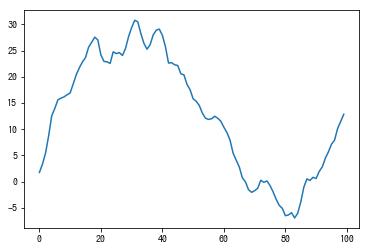

In [32]:
plt.plot(arima)

**自己回帰移動平均モデルのコレログラム**

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


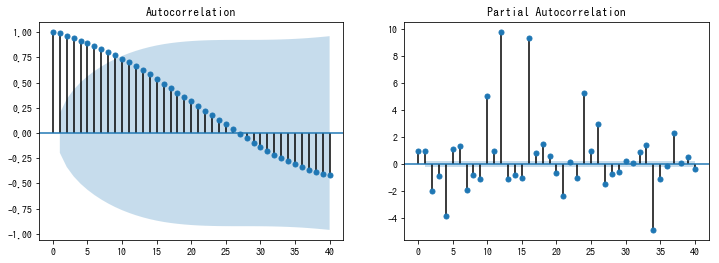

In [33]:
# そのまま

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sm.graphics.tsa.plot_acf(arima, lags=40, ax=ax1)
ax2 = plt.subplot(1,2,2)
sm.graphics.tsa.plot_pacf(arima, lags=40, ax=ax2)
plt.show()

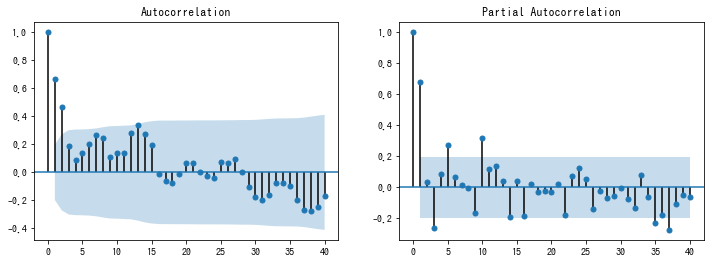

In [34]:
# 1階差分
arima_diff = np.diff(arima)

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sm.graphics.tsa.plot_acf(arima_diff, lags=40, ax=ax1)
ax2 = plt.subplot(1,2,2)
sm.graphics.tsa.plot_pacf(arima_diff, lags=40, ax=ax2)
plt.show()

In [35]:
from statsmodels.tsa.arima_model import ARIMA
m_ARIMA = ARIMA(sunspots, order=(1, 1, 1)).fit() # orderはp, d, qの順。

/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/localadmin/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [36]:
m_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.SUNACTIVITY   No. Observations:                  308
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1358.256
Method:                       css-mle   S.D. of innovations             19.893
Date:                Tue, 11 Jun 2019   AIC                           2724.512
Time:                        16:18:22   BIC                           2739.432
Sample:                             1   HQIC                          2730.478
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0014      2.298     -0.001      1.000      -4.506       4.503
ar.L1.D.SUNACTIVITY     0.4078      0.075      5.440      0.000       0.261       0.555
ma.L1.D.SUNACTIVITY     0.2042      0.070      2.898      0.004       0.066       0.342
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4523           +0.0000j            2.4523            0.0000
MA.1           -4.8968           +0.0000j            4.8968            0.5000
-----------------------------------------------------------------------------
"""

**モデルの評価指標**

In [37]:
m_ARIMA.bic 
# ベイズ情報量基準。低い方が予測量があると判断される。大データの場合も使える。

2739.432107922695

In [38]:
m_ARIMA.aic 
# 赤池情報量基準。低い方が予測量があると判断される。大データの場合は使えない。

2724.511708790801

In [ ]:
## ARIMA model(AutoRegressive Integrated Moving Average model, 差分自己回帰移動平均モデル)

## 宿題

In [39]:
nile = sm.datasets.nile.load_pandas().data
nile.set_index("year", inplace=True)

In [40]:
nile.rename(columns={"volume":"y"}, inplace=True)

In [41]:
nile.head()

,y
year,
1871.0,1120.0
1872.0,1160.0
1873.0,963.0
1874.0,1210.0
1875.0,1160.0


In [42]:
elnino = sm.datasets.elnino.load_pandas().data

In [43]:
elnino.columns = ["YEAR", "01","02","03","04","05","06","07","08","09","10","11","12"]

In [44]:
elnino = elnino.melt(id_vars="YEAR", var_name="Month",value_name="y")

In [45]:
elnino["yearmonth"] = elnino[["YEAR", "Month"]].apply(lambda x: str(int(x[0])) + x[1], axis=1)

In [46]:
elnino.drop(["YEAR", "Month"], axis=1, inplace=True)
elnino.set_index("yearmonth", inplace=True)

In [47]:
elnino.head()

,y
yearmonth,
195001,23.11
195101,24.19
195201,24.52
195301,24.15
195401,23.02


宿題用の時系列データとstatsmodelsを用いて、モデリングを行う。
データはnileとelninoを使用し、それぞれ計算すること。
- Level 1
    1. y列について、自己相関と偏自己相関のコレログラムをプロットせよ。どのようなことが言えそうか。
    2. y列についてARMA(1,1)でモデリングを行い、10期先まで予測を行え。
    3. y列について1階の差分を取り、ARMA(1,1)でモデリングを行い、10期先まで予測を行え。(ARIMA(1,1,1)となる)  
- Level 2
    4. y列に対して、ARIMAの次数をp,qを各々0~4の範囲で動かし、5 x 5 = 25種類のモデルをBICで評価せよ。BICが最良のモデルの次数はいくつであったか。また、最良のモデルについて、予測を行え。
    5. "2"で作成した差分のy列に対して、ARIMAの次数をp,qを各々0~4の範囲で動かし、5 x 5 = 25種類のモデルをBICで評価せよ。BICが最良のモデルの次数はいくつであったか。また、最良のモデルについて、予測を行え。  
- Level 3
    7. y列について単位根の有無を検定せよ。また、単位根を持つことを棄却できなかった場合、1階の差分について単位根があるか否かを検定せよ。
    8. "2", "3"で作成したモデルについて、誤差が正規分布に従うか否かを検定せよ。
    9. "2", "3"で作成したモデルについて、誤差に自己相関があるか否かを検定せよ。